<a id='toc'></a>
# Список тестов по запланированным локомотивам:

1. [Вычисление процента подвязки поездов и локомотивов.](#perc)
2. [Проверка правильности назначениях тяговых плеч локомотивам во входных данных.](#regions)
   1. [Проверка назначения тяговых плеч локомотивам в соответствии с сериями](#correct_reg_ser)
   2. [Проверка невыезда локомотива за пределы своих тяговых плеч в процессе планирования](#correct_reg_plan)
   3. [Локомотивы на чужих тяговых плечах на начало планирования](#bad_regs_loco_info)
3. [Проверка пунктов проведения ТО-2.](#st_to2)
4. [Проверка подвязки на соответствие весовым нормам.](#tonnage)
5. [Проверка смен локомотива на станциях обязательной смены.](#change)
6. [Анализ локомотивов резервом.](#res)
   1. [Проверка номеров поездов, соответствующих локомотивам резервом.](#res_nums)
   2. [Вычисление количества локомотивов резервом по направлениям.](#res_amount)
   3. [Проверка отправления локомотивов резервом до начала планирования.](#res_before)
   4. [Анализ отправления локомотивов резервом в четную сторону.](#res_even)
7. [Проверка скачков по времени назад](#time_leaps)
7. [Создание отчета](#report)

### Константы и настройки

In [1]:
report = ''
FOLDER = 'resources/'
REPORT_FOLDER = 'report/'
PRINT = True

### Функции для экспорта в HTML

In [2]:
def add_line(line, p=PRINT):    
    global report        
    if p:        
        if type(line) == str:
            print(line)        
        elif type(line) == pd.core.frame.DataFrame:
            print(line.to_string(index=False))
        elif type(line) == pd.core.series.Series:
            print(line.to_string())
    if type(line) == pd.core.frame.DataFrame:        
        report += ('%s<br>' % line.to_html(index=False))
    elif type(line) == pd.core.series.Series:
        report += ('%s<br>' % line.to_frame().reset_index().to_html(index=False))
    else:                
        report += ('%s<br>' % line)
    
def add_header(header, h=4, p=PRINT):
    global report    
    report += ('<h%d>%s</h%d>' % (h, header, h))    
    if p:
        print(header)
        
def add_image(filename):
    global report
    report += ('<img src="%s" alt="%s" height="40%%">' % (filename, filename))

def create_report(filename):
    global report
    report = report.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html_string = '''
        <html>
            <head>
                <link rel="stylesheet" href="skeleton.css">
                <style>body{ margin:20 20; background:whitesmoke; }
                table {table-layout : fixed}
                </style>
            </head>
            <body>
                <h1>Проверки по локомотивам</h1>        
                %s
            </body>
        </html>''' % (report)
    f = open(filename,'w', encoding='utf-8-sig')
    f.write(html_string)
    f.close()
    print('Отчет сформирован за %.2f сек. и записан в файл %s' % (time.time() - start_time, filename))

## Загрузка и подготовка данных

In [3]:
import numpy as np
import pandas as pd
import time, datetime
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import get_ipython

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rc('font', family='Times New Roman')

pd.set_option('max_rows', 50)
pd.set_option('display.max_colwidth', 25)

time_format = '%b %d, %H:%M'

start_time = time.time()
current_time   = pd.read_csv(FOLDER + 'current_time.csv').current_time[0]
twr            = pd.read_csv(FOLDER + 'team_work_region.csv', converters={'team_work_region':str})
links          = pd.read_csv(FOLDER + 'link.csv', converters={'st_from':str, 'st_to':str})
stations       = pd.read_csv(FOLDER + 'station.csv', converters={'station':str})
train_info     = pd.read_csv(FOLDER + 'train_info.csv', converters={'train': str, 'st_from':str, 'st_to':str})
train_plan     = pd.read_csv(FOLDER + 'slot_train.csv', converters={'train': str, 'st_from':str, 'st_to':str})
loco_info      = pd.read_csv(FOLDER + 'loco_attributes.csv', converters={'train':str, 'loco':str, 
                                                                   'st_from':str, 'st_to':str, 'depot':str})
loco_plan      = pd.read_csv(FOLDER + 'slot_loco.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str})
team_info      = pd.read_csv(FOLDER + 'team_attributes.csv', converters={'team':str,'depot':str, 'oper_location':str, \
                                                     'st_from':str, 'st_to':str, 'loco':str, 'depot_st':str})

team_plan      = pd.read_csv(FOLDER + 'slot_team.csv', converters={'team':str,'loco':str, 'st_from':str, 'st_to':str})
loco_series    = pd.read_csv(FOLDER + 'loco_series.csv')
loco_info_regs = pd.read_csv(FOLDER + 'loco_info_regs.csv', converters={'loco':str})
loco_tonnage   = pd.read_csv(FOLDER + 'loco_tonnage.csv', converters={'st_from':str, 'st_to':str})

st_names = stations[['station', 'name', 'esr']].drop_duplicates().set_index('station')
team_info.regions = team_info.regions.apply(literal_eval)

print('Log time: %d, %s' % (current_time, time.ctime(current_time)))
print('Read csvs:', np.round(time.time() - start_time, 2), 'sec')

Log time: 1465472474, Thu Jun  9 14:41:14 2016
Read csvs: 0.84 sec


In [4]:
# Мержим таблицы _plan и _info для поездов, локомотивов и бригад
# Добавляем во все таблицы названия станций на маршруте и времена отправления/прибытия в читабельном формате

def add_info(df):    
    if 'st_from' in df.columns:
        df['st_from_name'] = df.st_from.map(st_names.name)
    if 'st_to' in df.columns:
        df['st_to_name'] = df.st_to.map(st_names.name)
    if 'time_start' in df.columns:
        df['time_start_norm'] = df.time_start.apply(lambda x: time.strftime(time_format, time.localtime(x)))
    if 'time_end' in df.columns:
        df['time_end_norm'] = df.time_end.apply(lambda x: time.strftime(time_format, time.localtime(x)))
    if 'oper_location' in df.columns:
        df['oper_location_name'] = df.oper_location.map(st_names.name)    
        df.oper_location_name.fillna(0, inplace=True)
    if ('oper_location' in df.columns) & ('st_from' in df.columns) & ('st_to' in df.columns):        
        df['loc_name'] = df.oper_location_name
        df.loc[df.loc_name == 0, 'loc_name'] = df.st_from_name + ' - ' + df.st_to_name
    
add_info(train_plan)
add_info(loco_plan)
add_info(team_plan)
add_info(loco_info)
add_info(team_info)
train_plan = train_plan.merge(train_info, on='train', suffixes=('', '_info'), how='left')
loco_plan = loco_plan.merge(loco_info, on='loco', suffixes=('', '_info'), how='left')
team_plan = team_plan.merge(team_info, on='team', suffixes=('', '_info'), how='left')

In [5]:
# Добавляем ссылку на бригаду в таблицу локомотивов
# Добавляем ссылку на локомотив и бригаду в таблицу поездов

loco_plan['loco_time'] = list(zip(loco_plan.loco , loco_plan.time_start))
team_plan['loco_time'] = list(zip(team_plan.loco , team_plan.time_start))
loco_plan['team'] = loco_plan.loco_time.map(team_plan.drop_duplicates('loco_time').set_index('loco_time').team)

loco_plan['train_time'] = list(zip(loco_plan.train, loco_plan.time_start))
train_plan['train_time'] = list(zip(train_plan.train, train_plan.time_start))
train_plan['loco'] = train_plan.train_time.map(loco_plan.drop_duplicates('train_time').set_index('train_time').loco)
train_plan['team'] = train_plan.train_time.map(loco_plan.drop_duplicates('train_time').set_index('train_time').team)

add_info(loco_tonnage)
loco_tonnage['link'] = list(zip(loco_tonnage.st_from, loco_tonnage.st_to))
loco_tonnage['ssl'] = list(zip(loco_tonnage.series, loco_tonnage.sections, loco_tonnage.link))
loco_tonnage['ser_name'] = loco_tonnage.series.map(loco_series.set_index('ser_id').ser_name)

<a =id='perc'></a>
## Вычисление процента подвязки поездов и локомотивов [ToC](#toc)

In [6]:
def count_assign_percent(horizon):
    mask = (train_plan.time_start < current_time + horizon)
    bad_trains = train_plan.loc[mask & (train_plan.loco.isnull())]
    bad_trains_n = bad_trains.drop_duplicates('train').train.count()
    good_percent = 100 * (1 - bad_trains_n / total_trains_n)        
    return 'Процент подвязки поездов и локомотивов на горизонте в %2.d часов: %.2f%% (поездов без локомотива - %d)'\
         % (horizon / 3600, good_percent, bad_trains_n)

train_plan['train_type'] = train_plan.train.apply(lambda x: int(str(x)[0]))
total_trains_n = train_plan[train_plan.train_type.isin([2, 9])].drop_duplicates('train').train.count()
add_header('Вычисление процента подвязки поездов и локомотивов', p=False, h=2)
add_line(count_assign_percent(6 * 3600))
add_line(count_assign_percent(12 * 3600))
add_line(count_assign_percent(24 * 3600))
add_line(count_assign_percent(48 * 3600))

Процент подвязки поездов и локомотивов на горизонте в  6 часов: 94.87% (поездов без локомотива - 220)
Процент подвязки поездов и локомотивов на горизонте в 12 часов: 92.33% (поездов без локомотива - 329)
Процент подвязки поездов и локомотивов на горизонте в 24 часов: 88.00% (поездов без локомотива - 515)
Процент подвязки поездов и локомотивов на горизонте в 48 часов: 82.35% (поездов без локомотива - 757)


In [7]:
a = train_plan[(train_plan.time_start < current_time + 24 * 3600) & (train_plan.loco.isnull())]\
    .drop_duplicates('train')\
    .groupby(['st_from_name', 'st_to_name']).train\
    .count().sort_values(ascending=False)
add_header('Направления, на которые не удалось подвязать локомотив под поезд (первые 10 по количеству поездов):')
add_line(a.head(10))
a.to_csv('a.csv')

Направления, на которые не удалось подвязать локомотив под поезд (первые 10 по количеству поездов):
st_from_name                        st_to_name 
ТАЙШЕТ                              БАЙРОНОВКА     17
ЗАБАЙКАЛЬСК                         ХАРАНОР        17
УССУРИЙСК                           БАРАНОВСКИЙ    14
МАРИИНСК                            БОГОТОЛ        13
ТЫНДА                               ШАХТАУМ        10
НАХОДКА                             КУЗНЕЦОВО      10
ТАЙШЕТ                              ТОРЕЯ           9
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ  МЫЛКИ           9
НОВЫЙ УРГАЛ                         УРГАЛ I         8
ТАКСИМО                             КУАНДА          7


In [8]:
(st_name, st2_name) = a.index[0]
train_cols = ['train', 'weight', 'st_from_name', 'st_to_name', 'st_dest_name', 'time_start_norm', 'time_end_norm', 'loco', 'team']
cols = ['train', 'weight', 'st_from_name', 'st_to_name', 'st_dest_name', 'time_start_norm', 'loco', 'ser_name', 'sections']
routes = pd.read_csv(FOLDER + 'routes.csv', converters={'st_from':str, 'st_to':str, 'train':str})
add_info(routes)
routes['end'] = routes.train != routes.train.shift(-1)
train_plan['st_dest_name'] = train_plan.train.map(routes[routes.end].set_index('train').st_to_name)
loco_info['ser_name'] = loco_info.series.map(loco_series.set_index('ser_id').ser_name)
train_plan['ser_name'] = train_plan.loco.map(loco_info.set_index('loco').ser_name)
train_plan['sections'] = train_plan.loco.map(loco_info.set_index('loco').sections)
a = train_plan[(train_plan.time_start < current_time + 24 * 3600) 
               & (train_plan.loco.isnull())
               & (train_plan.st_dest_name.isnull() == False)
               & (train_plan.st_from_name == st_name)].drop_duplicates('train')
add_header('Поезда со станции %s, к которым не были подвязаны локомотивы' % st_name)
add_line(a.sort_values('time_start')[cols])

Поезда со станции ТАЙШЕТ, к которым не были подвязаны локомотивы
        train  weight st_from_name  st_to_name       st_dest_name time_start_norm loco ser_name  sections
 220200275273    6020       ТАЙШЕТ  БАЙРОНОВКА  НАХОДКА-ВОСТОЧНАЯ   Jun 09, 14:41  NaN      NaN       NaN
 220200058589    5981       ТАЙШЕТ  БАЙРОНОВКА  НАХОДКА-ВОСТОЧНАЯ   Jun 09, 14:41  NaN      NaN       NaN
 220200265386    5992       ТАЙШЕТ  БАЙРОНОВКА             ВАНИНО   Jun 09, 14:41  NaN      NaN       NaN
 220200704735    6028       ТАЙШЕТ  БАЙРОНОВКА           ГВОЗДЕВО   Jun 09, 14:41  NaN      NaN       NaN
 220201205815    6017       ТАЙШЕТ       ТОРЕЯ             ДЗЕМГИ   Jun 09, 14:41  NaN      NaN       NaN
 220200318629    5965       ТАЙШЕТ  БАЙРОНОВКА             ВАНИНО   Jun 09, 14:41  NaN      NaN       NaN
 210208176776    5989       ТАЙШЕТ  БАЙРОНОВКА             ВАНИНО   Jun 09, 14:41  NaN      NaN       NaN
 210211642434    5979       ТАЙШЕТ       ТОРЕЯ               ЛЕНА   Jun 09, 17:40  NaN 

In [9]:
a[a.weight != 0][cols].sort_values('weight')
st2 = 'ХАБАРОВСК II'
st1 = 'КАРЫМСКАЯ'
train_id = '200248755762'
train_plan['link'] = list(zip(train_plan.st_from, train_plan.st_to))
route = train_plan[(train_plan.train == train_id) & (train_plan.loco.isnull())].link
ton_cols = ['ser_name', 'sections', 'st_from_name', 'st_to_name', 'max_weight']
loco_tonnage[(loco_tonnage.link.isin(route)) & (loco_tonnage.ser_name == '3ЭС5К')][ton_cols].groupby(['st_from_name', 'st_to_name', 'sections']).max_weight.unique()

Series([], Name: max_weight, dtype: float64)

<a =id='regions'></a>
## Проверка наличия локомотивов только на своих тяговых плечах [ToC](#toc)

In [10]:
add_header('Проверка наличия локомотивов только на своих тяговых плечах', h=2, p=False)

<a id='correct_reg_ser'></a>
### Проверка назначения тяговых плеч локомотивам в соответствии с сериями [ToC](#toc)

In [11]:
add_header('Проверка назначения тяговых плеч локомотивам в соответствии с сериями', h=3, p=False)

In [12]:
def func(df, stations, st):    
    a = links.loc[(links.st_from_name.isin(st))].st_from_name.value_counts()
    b = links.loc[(links.st_from_name.isin(st)) & (links.st_to_name.isin(st))].st_from_name.value_counts()
    c = a.to_frame().join(b, rsuffix='_reg')
    c['delta'] = c.st_from_name - c.st_from_name_reg    
    d = c.join(stations[['name', 'norm_time']].drop_duplicates().set_index('name'), how='right')
    e = d.loc[((d.delta > 0) | (d.st_from_name == 1))]
    return sorted(e.index.values)

add_info(links)
loco_info['regions_eval'] = loco_info.regions.apply(literal_eval)
stations_regs = stations.groupby('station').loco_region.apply(lambda x: x.values)
loco_info['ser_name'] = loco_info.series.map(loco_series.set_index('ser_id').ser_name)
reg_st = stations.groupby('loco_region')['name'].unique().to_frame()
reg_st['short_name'] = reg_st['name'].apply(lambda x: func(links, stations, x))
reg_st.columns = ['stations', 'reg_name']
reg_borders = pd.read_csv(FOLDER + 'loco_reg_borders.csv', encoding='utf-8-sig')
bord = reg_borders.station.values
reg_st['short_name'] = reg_st.reg_name.apply(lambda x: np.intersect1d(x, bord) if len(np.intersect1d(x, bord)) > 1 else [])
big_borders = ['МАРИИНСК', 'БОРЗЯ', 'КАРЫМСКАЯ', 'ХАБАРОВСК II', 'МЕЖДУРЕЧЕНСК', 'ТАКСИМО', 'КОМСОМОЛЬСК-НА-АМУРЕ']
reg_st['short_name'] = reg_st.short_name.apply(lambda x: np.intersect1d(x, big_borders) if len(x) > 2 else x)
pd.set_option('display.max_colwidth', 60)
print(reg_st[['short_name']].to_string())
#reg_st.ix[2002119307].reg_name

                                                  short_name
loco_region                                                 
2002119282                                    [АБАЗА, АСКИЗ]
2002119284                               [АБАКАН, АЧИНСК II]
2002119286                           [АЧИНСК I, ЛЕСОСИБИРСК]
2002119287                         [БЕЛОГОРСК, БЛАГОВЕЩЕНСК]
2002119288                              [БОРЗЯ, ЗАБАЙКАЛЬСК]
2002119290                         [ПОЯРКОВО, ХОЛОДНЫЙ КЛЮЧ]
2002119292                        [ГРОДЕКОВО (КИТАЙ), ХАСАН]
2002119294                         [КАРЫМСКАЯ, ХАБАРОВСК II]
2002119296   [КОМСОМОЛЬСК-НА-АМУРЕ, СОВЕТСКАЯ ГАВАНЬ- ГОРОД]
2002119297                                                []
2002119299                                 [БОРЗЯ, МАРИИНСК]
2002119301                           [МЕЖДУРЕЧЕНСК, ТАКСИМО]
2002119303                                  [ТАКСИМО, ТЫНДА]
2002119305                        [ИЗВЕСТКОВАЯ, НОВЫЙ УРГАЛ]
2002119307              

In [13]:
def save_to_excel(df, filename=FOLDER + 'reg_ser.xlsx'):    
    df.to_excel(filename)
    print('Excel file %s created' % filename)

loco_info['ser_name'] = loco_info.series.map(loco_series.set_index('ser_id').ser_name)
loco_info['ser_desc'] = loco_info.series.map(loco_series.set_index('ser_id').ser_desc)
loco_info['ser_type'] = loco_info.series.map(loco_series.set_index('ser_id').ser_type)
loco_info_regs['number'] = loco_info.loco.map(loco_info.drop_duplicates('loco').set_index('loco').number)
loco_info_regs['reg_name'] = loco_info_regs.region.map(reg_st.short_name)
loco_info_regs['ser_name'] = loco_info_regs.loco.map(loco_info.set_index('loco').ser_name)
loco_info_regs['ser_type'] = loco_info_regs.loco.map(loco_info.set_index('loco').ser_type)
loco_info_regs['reg_name_str'] = loco_info_regs.reg_name.apply(str)
loco_info_regs['ltype'] = loco_info_regs.loco.map(loco_info.set_index('loco').ltype)
loco_info_regs.sort_values(['ser_name', 'reg_name_str'])[['loco', 'ser_name', 'reg_name']].set_index('loco')\
                .to_excel(FOLDER + 'ans.xlsx')
a = loco_info_regs.groupby('reg_name_str').ser_name.unique()
loco_info_regs['ser_desc'] = loco_info_regs.ser_name.map(loco_series.drop_duplicates('ser_name').set_index('ser_name').ser_desc)
a = loco_info_regs.loc[(loco_info_regs.ltype == 1) & (loco_info_regs.ser_desc.isin(['Грузовое', 'Грузопассажирское']))]\
            .groupby(['region', 'reg_name_str']).ser_name.unique().to_frame()
b = loco_info_regs.loc[(loco_info_regs.ltype == 1) & (loco_info_regs.ser_desc.isin(['Грузовое', 'Грузопассажирское']))]\
            .groupby(['region', 'reg_name_str']).ser_type.unique().to_frame()
c = a.join(b)
d = c.join(loco_info_regs.loc[loco_info_regs.ltype == 1].groupby(['region', 'reg_name_str']).loco.count())
print('Total locos:', loco_info.loco.drop_duplicates().count())
print('Freight locos:', loco_info.loc[loco_info.ser_desc.isin(['Грузовое', 'Грузопассажирское'])].loco.drop_duplicates().count())
print('Locos of type = 1:', loco_info[loco_info.ltype == 1].loco.drop_duplicates().count())
pd.set_option('display.max_colwidth', 40)
add_line(d.reset_index().sort_values('loco', ascending=False))
#save_to_excel(d)

Total locos: 1584
Freight locos: 1459
Locos of type = 1: 1396
     region                             reg_name_str                                 ser_name      ser_type  loco
 2002119299                     ['БОРЗЯ' 'МАРИИНСК']  [ВЛ85, ВЛ80Р, ВЛ80С, 2ЭС5К, 3ЭС5К, В...  [Электровоз]   507
 2002119294             ['КАРЫМСКАЯ' 'ХАБАРОВСК II']                    [3ЭС5К, ВЛ80С, 2ЭС5К]  [Электровоз]   466
 2002119320           ['СМОЛЯНИНОВО' 'ХАБАРОВСК II']                    [ВЛ80С, 3ЭС5К, 2ЭС5К]  [Электровоз]   197
 2002119301               ['МЕЖДУРЕЧЕНСК' 'ТАКСИМО']     [ВЛ80ТК, 2ЭС5К, 3ЭС5К, ВЛ80С, ВЛ80Т]  [Электровоз]   170
 2002119296  ['КОМСОМОЛЬСК-НА-АМУРЕ' 'СОВЕТСКАЯ Г...  [3ТЭ10МК, 2ТЭ10М, 2ТЭ10МК, 3ТЭ10УК, ...    [Тепловоз]    89
 2002119305            ['ИЗВЕСТКОВАЯ' 'НОВЫЙ УРГАЛ']  [3ТЭ10МК, 2ТЭ10МК, 2ТЭ10М, 3ТЭ10УК, ...    [Тепловоз]    59
 2002119317                  ['СКОВОРОДИНО' 'ТЫНДА']  [3ТЭ10МК, 2ТЭ25А, 2ТЭ10МК, 2ТЭ10М, 2...    [Тепловоз]    59
 2002119312      ['НАХОДКА

In [14]:
reg_ser = d.reset_index()[['region', 'ser_type']]

<a id='correct_reg_plan'></a>
### Проверка выезда локомотивов за пределы своих тяговых плеч [ToC](#toc)

In [15]:
add_header('Проверка выезда локомотивов за пределы своих тяговых плеч', h=3, p=False)

#### Добавляем тяговое плечо в таблицу линков

In [16]:
stations['regions'] = stations.station.map(stations.groupby('station').loco_region.unique())
stations_unique = stations.drop_duplicates('station').set_index('station')
links['st_from_regs'] = links.st_from.map(stations_unique.regions)
links['st_to_regs'] = links.st_to.map(stations_unique.regions)
links['regs'] = links.st_from_regs.combine(links.st_to_regs, np.intersect1d)
links['link'] = list(zip(links.st_from, links.st_to))
regs = reg_st.reset_index()
links['reg_name'] = links.regs.apply(lambda x: regs[regs.loco_region.isin(x)].short_name.values)

#### Добавляем текущее тяговое плечо в каждый участок планов по локомотивам

In [17]:
loco_plan['curr_reg'] = loco_plan.link.map(links.drop_duplicates('link').set_index('link').regs)
loco_plan['curr_reg_name'] = loco_plan.link.map(links.drop_duplicates('link').set_index('link').reg_name)
loco_plan['regions'] = loco_plan.loco.map(loco_info.set_index('loco').regions_eval)
loco_info['reg_names'] = loco_info.regions_eval.apply(lambda x: \
                                                      regs[regs.loco_region.isin([int(i) for i in x])].short_name.values)
loco_plan['reg_names'] = loco_plan.loco.map(loco_info.set_index('loco').reg_names)

#### Вычисляем, есть у локомотива текущее тяговое плечо в списке разрешенных

In [18]:
loco_plan['ok_reg'] = loco_plan.curr_reg.combine(loco_plan.regions, np.intersect1d).apply(len) > 0

#### Вычисляем тяговое плечо на исходном местоположении локомотива

In [19]:
def get_current_region(row):
    if row.st_from == '-1':        
        a = links[links.st_from == row.oper_location].regs.values
    else:
        a = links[(links.st_from == row.st_from) & (links.st_to == row.st_to)].regs.values
    return list(np.concatenate(a) if len(a) > 0 else [])
        
loco_info['location'] = list(zip(loco_info.oper_location, loco_info.st_from, loco_info.st_to))
loco_info['curr_reg'] = loco_info.apply(lambda row: get_current_region(row), axis=1)

#### Вычисляем, находится ли локомотив на своем тяговом плече на начало планирования

In [20]:
loco_info['ok_reg'] = loco_info.curr_reg.combine(loco_info.regions_eval, np.intersect1d).apply(len) > 0
loco_plan['info_ok_reg'] = loco_plan.loco.map(loco_info.drop_duplicates('loco').set_index('loco').ok_reg)

#### Составляем список локомотивов, выезжающих за пределы своих ТП в процессе планирования

In [21]:
loco_out_of_regs = loco_plan[(loco_plan.curr_reg_name.isnull() == False) 
                             & (loco_plan.ok_reg == False) & (loco_plan.info_ok_reg == True)]
cols = ['loco', 'ser_name', 'reg_names', 'st_from_name', 'st_to_name', 'train', 'state', 'loc_name']
add_line('Всего %d локомотивов, выезжающих за пределы своих тяговых плеч в процессе планирования:' 
           % loco_out_of_regs.loco.drop_duplicates().count())
add_line('- %d следуют резервом;' % (loco_out_of_regs[loco_out_of_regs.state == 0].loco.drop_duplicates().count()))
add_line('- %d с поездами.' % (loco_out_of_regs[loco_out_of_regs.state == 1].loco.drop_duplicates().count()))

pd.set_option('display.max_colwidth', 40)
states = sorted(loco_out_of_regs.state.unique())
for s in states:
    add_header('\nПримеры локомотивов в состоянии %d за пределами своих тяговых плеч:' % s)
    add_line(loco_out_of_regs[loco_out_of_regs.state == s].drop_duplicates('loco')[cols].head(5))

Всего 0 локомотивов, выезжающих за пределы своих тяговых плеч в процессе планирования:
- 0 следуют резервом;
- 0 с поездами.


<a id='bad_regs_loco_info'></a>
### Локомотивы на чужих тяговых плечах на начало планирования [ToC](#toc)

In [22]:
add_header('Локомотивы на чужих тяговых плечах на начало планирования', h=3, p=False)

In [23]:
cols = ['loco', 'ser_name', 'loc_name', 'reg_names']
bad_regs_loco_info = loco_info[(loco_info.ltype == 1) & (loco_info.ok_reg == False)]
add_header('Всего %d локомотивов на чужих тяговых плечах на начало планирования' % bad_regs_loco_info.loco.count())
add_header('\nРаспределение по сериям (показаны первые 5):')
add_line(bad_regs_loco_info[cols].ser_name.value_counts().head())
add_header('\nРаспределение по тяговым плечам локомотивов (показаны первые 5):')
add_line(bad_regs_loco_info[cols].reg_names.value_counts().head())
add_header('\nПримеры локомотивов:')
add_line(bad_regs_loco_info[cols].head(20))

Всего 111 локомотивов на чужих тяговых плечах на начало планирования

Распределение по сериям (показаны первые 5):
3ТЭ10МК    24
2ТЭ10М     16
ВЛ80Р      14
2ТЭ10МК    14
2ЭС5К       8

Распределение по тяговым плечам локомотивов (показаны первые 5):
[[СКОВОРОДИНО, ТЫНДА]]         28
[[БОРЗЯ, МАРИИНСК]]            17
[[КАРЫМСКАЯ, ХАБАРОВСК II]]    13
[[АЧИНСК I, ЛЕСОСИБИРСК]]       8
[[МЕЖДУРЕЧЕНСК, ТАКСИМО]]       6

Примеры локомотивов:
         loco ser_name                  loc_name                                reg_names
 200200104344  3ТЭ10МК                 ФЕВРАЛЬСК                   [[СКОВОРОДИНО, ТЫНДА]]
 200200039490   2ТЭ10В                 БАМОВСКАЯ                   [[БОРЗЯ, ЗАБАЙКАЛЬСК]]
 200200088698   2ТЭ10У      АЧИНСК II - АЧИНСК I                [[АЧИНСК I, ЛЕСОСИБИРСК]]
 200200062912   2ТЭ10М  АМАЗАР - ЕРОФЕЙ ПАВЛОВИЧ                   [[БОРЗЯ, ЗАБАЙКАЛЬСК]]
 200200377386  2ТЭ10МК               НОВЫЙ УРГАЛ                   [[СКОВОРОДИНО, ТЫНДА]]
 200200080996    

<a =id='st_to2'></a>
## Проверка пунктов проведения ТО-2 [ToC](#toc)

In [24]:
add_header('Проверка планирования ТО-2', h=2, p=False)

In [25]:
to2_type = 2001889869
service = pd.read_csv(FOLDER + 'service.csv', converters={'station':str})
service['st_name'] = service.station.map(st_names.name)
service['dur_h'] = np.round((service.duration / 3600), 2)
to2 = service[service.serv_type == to2_type].drop_duplicates()
to2_dur_median = to2.dur_h.median()
add_header('Пункты проведения ТО-2 во входных данных:')
add_line(to2[['st_name', 'dur_h']].sort_values('st_name'))
add_line('Медианное время проведения ТО-2: %.2f часа' % to2_dur_median)

Пункты проведения ТО-2 во входных данных:
               st_name  dur_h
                АБАКАН   0.98
               БОГОТОЛ   0.95
             ВИХОРЕВКА   0.90
                  ЗИМА   1.00
              ИЛАНСКАЯ   1.01
 ИРКУТСК-СОРТИРОВОЧНЫЙ   0.91
  КОМСОМОЛЬСК-НА-АМУРЕ   1.08
             МАГДАГАЧИ   0.90
           НИЖНЕУДИНСК   0.90
            НОВАЯ ЧАРА   1.08
           НОВЫЙ УРГАЛ   1.08
       СЕВЕРОБАЙКАЛЬСК   0.90
           СМОЛЯНИНОВО   0.90
                 ТЫНДА   1.08
                  УЖУР   1.01
              УЛАН-УДЭ   1.00
                ЧИТА I   0.91
Медианное время проведения ТО-2: 0.98 часа


In [26]:
loco_plan['tt'] = loco_plan.time_end - loco_plan.time_start
plan_to = loco_plan[loco_plan.state == 4][['loco', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'tt']]
add_header('Проведение ТО запланировано на %d разных станциях (показаны первые 10):' 
           % plan_to.st_from_name.drop_duplicates().count())
stats_plan_to = plan_to.st_from_name.value_counts().to_frame().join(plan_to.groupby('st_from_name').tt.median())
stats_plan_to.columns = ['num', 'time']
stats_plan_to['time_h'] = np.round((stats_plan_to.time / 3600), 2)
add_line(stats_plan_to[['num', 'time_h']].reset_index().head(20))

Проведение ТО запланировано на 16 разных станциях (показаны первые 10):
                 index  num  time_h
             МАГДАГАЧИ  112    0.90
                ЧИТА I   44    0.91
           СМОЛЯНИНОВО   42    0.90
               БОГОТОЛ   34    0.95
                 ТЫНДА   33    1.08
              ИЛАНСКАЯ   29    1.01
  КОМСОМОЛЬСК-НА-АМУРЕ   28    1.08
              УЛАН-УДЭ   24    1.00
             ВИХОРЕВКА   20    0.90
 ИРКУТСК-СОРТИРОВОЧНЫЙ   18    0.91
                АБАКАН   17    0.98
           НИЖНЕУДИНСК   11    0.90
                  ЗИМА    7    1.00
       СЕВЕРОБАЙКАЛЬСК    6    0.90
           НОВЫЙ УРГАЛ    3    1.08
            НОВАЯ ЧАРА    2    1.08


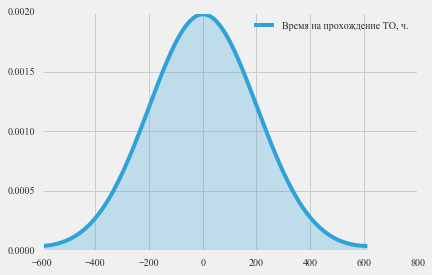

In [27]:
cols = ['loco', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'state', 'tt']
plan_to = loco_plan[loco_plan.state == 4]
plan_to[plan_to.tt > 10 * 3600].sort_values('time_start')[cols]
sns.kdeplot(plan_to.tt / 3600, shade=True, bw=200, label='Время на прохождение ТО, ч.')

In [28]:
print(loco_plan[loco_plan.loco == '200200068390'][cols].to_string(index=False))

         loco           st_from_name             st_to_name time_start_norm  time_end_norm  state     tt
 200200068390                 ЧИТА I              КАРЫМСКАЯ   Jun 09, 04:57  Jun 09, 07:06      1   7793
 200200068390              КАРЫМСКАЯ                 ЧИТА I   Jun 09, 17:02  Jun 09, 19:17      0   8076
 200200068390                 ЧИТА I                 ЧИТА I   Jun 09, 19:17  Jun 09, 20:11      4   3262
 200200068390                 ЧИТА I                 КАДАЛА   Jun 10, 03:15  Jun 10, 03:31      1    990
 200200068390                 КАДАЛА                 ЛЕСНАЯ   Jun 10, 03:31  Jun 10, 04:23      1   3093
 200200068390                 ЛЕСНАЯ               ТУРГУТУЙ   Jun 10, 04:23  Jun 10, 05:13      1   3025
 200200068390               ТУРГУТУЙ                 МОГЗОН   Jun 10, 05:13  Jun 10, 06:18      1   3917
 200200068390                 МОГЗОН                  ХИЛОК   Jun 10, 06:18  Jun 10, 08:32      1   8045
 200200068390                  ХИЛОК                 МО

<a =id='tonnage'></a>
## Проверка подвязки на соответствие весовым нормам [ToC](#toc)

In [29]:
add_header('Проверка подвязки на соответствие весовым нормам', h=2, p=False)

### Маска времени

In [30]:
#Ниже надо раскомментировать соответствующую строчку для нужного анализа

def time_mask(df):
    # Маска для анализа поездов, которые запланировал планировщик (отправленных после начала планирования)
    return df.time_start >= current_time
    # Маска для анализа позедов, отправленных до начала планирования (следующих по факту)
    #time_mask = overweight.time_start < current_time

### Проверка соответствия результатов планирования справочнику весовых норм

In [31]:
print(time.ctime(current_time))
loco_plan['ser_name'] = loco_plan.series.map(loco_series.set_index('ser_id').ser_name)
loco_tonnage = pd.read_csv(FOLDER + 'loco_tonnage.csv', converters={'st_from':str, 'st_to':str})
loco_tonnage['link'] = list(zip(loco_tonnage.st_from, loco_tonnage.st_to))
loco_tonnage['ssl'] = list(zip(loco_tonnage.series, loco_tonnage.sections, loco_tonnage.link))
loco_plan['link'] = list(zip(loco_plan.st_from, loco_plan.st_to))
loco_plan['link_name'] = list(zip(loco_plan.st_from_name, loco_plan.st_to_name))
loco_plan['ssl'] = list(zip(loco_plan.series, loco_plan.sections, loco_plan.link))
loco_plan['max_weight'] = loco_plan.ssl.map(loco_tonnage.groupby('ssl').max_weight.max().to_frame().max_weight)
loco_plan['train_weight'] = loco_plan.train.map(train_info.drop_duplicates('train').set_index('train').weight)
loco_plan['overweight'] = loco_plan.train_weight - loco_plan.max_weight
cols = ['loco', 'ser_name', 'st_from_name', 'st_to_name', 'time_start_norm', 'max_weight', 'train_weight', 'overweight', 'train']
overweight = loco_plan[(loco_plan.overweight > 0)].dropna(subset=['max_weight']).drop_duplicates(subset=['loco', 'train'])
overweight_plan = overweight[time_mask(overweight)] # <<<<<<<<<<<<<<<<<<<<<<<<<<<<< TIME_MASK -----------------------
overweight_n = len(overweight_plan.index)
add_header('Всего %d подвязок локомотивов к поезду с нарушением весовых норм (показаны первые 10):' % overweight_n)
pd.set_option('display.max_colwidth', 15)
add_line(overweight_plan.sort_values('overweight', ascending=False).head(10)[cols])

overweight_no_joint = overweight_plan[overweight_plan.train_weight < 10000]
add_header('\nВсего %d подвязок локомотивов к поездам (за исключением сдвоенных) с нарушением весовых норм (показаны первые 10):' 
      % len(overweight_no_joint.index))
add_line(overweight_no_joint.sort_values('overweight', ascending=False).head(10)[cols])

Thu Jun  9 14:41:14 2016
Всего 73 подвязок локомотивов к поезду с нарушением весовых норм (показаны первые 10):
         loco ser_name    st_from_name      st_to_name time_start_norm  max_weight  train_weight  overweight         train
 200200092244    ВЛ80Р      КАСЬЯНОВКА          МАЛЬТА   Jun 09, 16:10        6300         11833        5533  220200910637
 200200030522  3ТЭ10МК  КОМСОМОЛЬСК...         СЕЛИХИН   Jun 10, 03:25        3600          5568        1968  210207292866
 200200070118  3ТЭ10МК  КОМСОМОЛЬСК...         СЕЛИХИН   Jun 10, 15:35        3600          5552        1952  210205572478
 200200087697  3ТЭ10УК  КОМСОМОЛЬСК...         СЕЛИХИН   Jun 10, 07:05        3600          5549        1949  210209846899
 200200081281   ВЛ80ТК     КОШУРНИКОВО       ЩЕТИНКИНО   Jun 09, 15:40        4000          5875        1875  220200864446
 200200077959    3ЭС5К         ТАКОВКА          НЕБЕЛЬ   Jun 09, 17:34        3000          4849        1849  220200655738
 200200104714    ВЛ80Р     

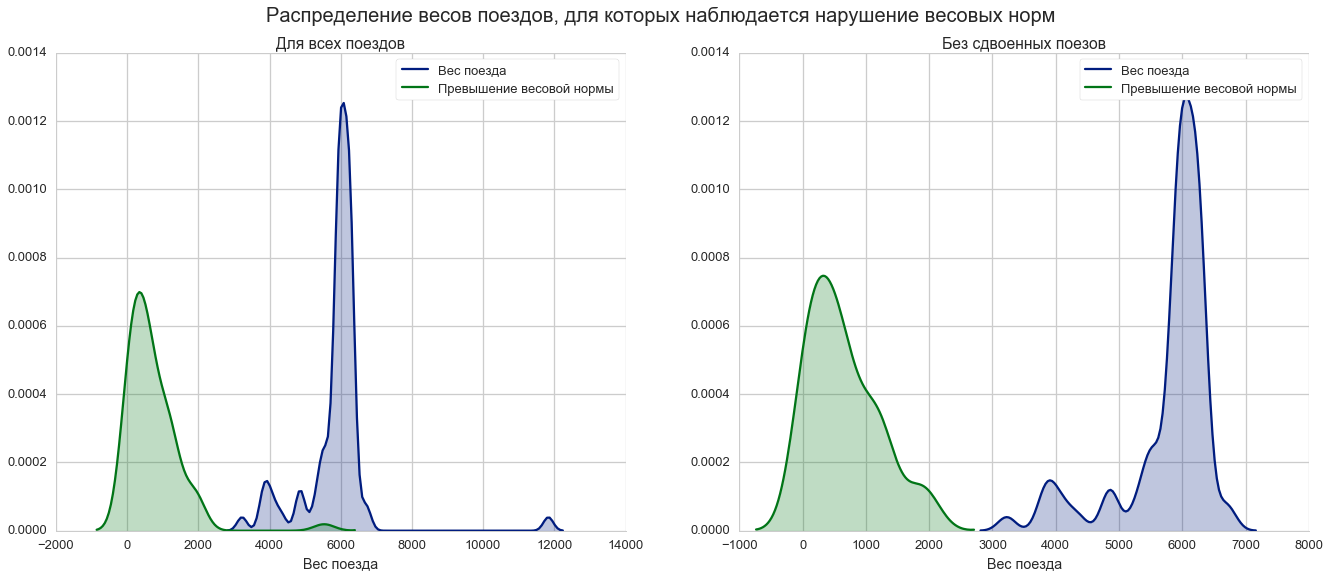

In [32]:
sns.set(style='whitegrid', context='talk')
sns.set_color_codes('dark')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
sns.distplot(overweight_plan.train_weight, hist=False, color='b', 
             kde_kws={'shade':True, 'label':'Вес поезда'}, ax=ax[0])
sns.distplot(overweight_plan.overweight, hist=False, color='g', 
             kde_kws={'shade':True, 'label':'Превышение весовой нормы'}, ax=ax[0])
sns.distplot(overweight_no_joint.train_weight, hist=False, color='b', 
             kde_kws={'shade':True, 'label':'Вес поезда'}, ax=ax[1])
sns.distplot(overweight_no_joint.overweight, hist=False, color='g', 
             kde_kws={'shade':True, 'label':'Превышение весовой нормы'}, ax=ax[1])
title = 'Для всех поездов'
title_nj = 'Без сдвоенных поезов'
ax[0].set(title=title, xlabel='Вес поезда')
ax[1].set(title=title_nj, xlabel='Вес поезда')
ax[0].legend(frameon=True)
ax[1].legend(frameon=True)
plt.suptitle('Распределение весов поездов, для которых наблюдается нарушение весовых норм', fontsize=20)
sns.despine()
filename = 'weight_error.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

In [33]:
add_header('Распределение нарушений весовых норм по участкам (первые 5):')
a = overweight_no_joint.link_name.value_counts()
b = overweight_no_joint.groupby('link_name').overweight.median()
overweight_links = a.to_frame().join(b)
overweight_links.columns = ['number', 'overw_median']
pd.set_option('display.max_colwidth', 50)
add_line(overweight_links.reset_index().head())

add_header('\nРаспределение нарушений весовых норм по сериям локомотивов:')
a = overweight_no_joint.ser_name.value_counts()
b = overweight_no_joint.groupby('ser_name').overweight.median()
overweight_ser = a.to_frame().join(b)
overweight_ser.columns = ['number', 'overw_median']
add_line(overweight_ser.reset_index())

Распределение нарушений весовых норм по участкам (первые 5):
                                         index  number  overw_median
                               (ХИЛОК, МОГЗОН)      30         499.5
                     (АМУРСКИЙ ЗАЛИВ, УГЛОВАЯ)      12        1122.5
 (КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ, СЕЛИХИН)       5        1949.0
           (ЧЕРНЫШЕВСК-ЗАБАЙКАЛЬСКИЙ, ЖИРЕКЕН)       2         394.5
                             (ТАКОВКА, НЕБЕЛЬ)       2        1489.0

Распределение нарушений весовых норм по сериям локомотивов:
   index  number  overw_median
   3ЭС5К      24         942.0
    ВЛ85      19         256.0
   ВЛ80Р      14         634.0
  ВЛ80ТК       5          20.0
 3ТЭ10МК       4        1611.5
   ВЛ80С       3         463.0
  2ТЭ10В       1        1253.0
 3ТЭ10УК       1        1949.0
  2ТЭ10У       1           9.0


### Причины нарушений весовых норм:

1. На участке Торея-Турма почему-то задан максимальный вес для серии 3ЭС5К = 3000 тонн, хотя на прилегающих участках для этой же серии задан максимальный вес 6000 тонн.
  1. Видимо, при загрузке был пропущен фрагмент с подталкивающими локомотивами. Похоже, на участке Торея-Турма нужно подталкивание (при наличии подталкивающего локомотива норма сразу подскакивает до 6000).
  2. Аналогичная ситуация с участком Кунерма-Дабан. Но там подталкивания нет и в справочнике (экселевской таблице). Возможно, его просто забыли?
2. Для участка Хилок-Могзон в справочнике указаны максимальные значения весов 5500-5700. Многие поезда имеют вес 6000-6200, так что наблюдается небольшое превышение (среднее значение превышения - на 433т.), но случаев превышения довольно много. Вопрос к технологам: 1) исправлять справочник? 2) есть какой-то нюанс планирования? толкание? 3) оставить, как есть? Аналогично для участка Амурский Залив -- Угловая (там норма 5000).

In [34]:
cols = ['loco', 'ser_name', 'st_from_name', 'st_to_name', 'time_start_norm', 'max_weight', 'train_weight', 'overweight', 'train']
add_info(loco_tonnage)
loco_tonnage['ser_name'] = loco_tonnage.series.map(loco_series.set_index('ser_id').ser_name)
a = overweight_no_joint.loc[(overweight_no_joint.st_from_name == 'ХИЛОК')]
a[cols]
tcols = ['ser_name', 'sections', 'st_from_name', 'st_to_name', 'max_weight']
print(loco_tonnage.loc[(loco_tonnage.ser_name == '3ЭС5К') 
                       & ((loco_tonnage.st_from_name == 'ХИЛОК'))][tcols].to_string(index=False))

ser_name  sections st_from_name st_to_name  max_weight
   3ЭС5К         3        ХИЛОК   ЖИПХЕГЕН        6300
   3ЭС5К         3        ХИЛОК     МОГЗОН        5700


<a =id='change'></a>
## Проверка смены локомотивов на станциях обязательной смены [ToC](#toc)

In [35]:
add_header('Проверка смены локомотивов на станциях обязательной смены', h=2, p=False)

In [36]:
hor = 24 * 3600
cols = ['train', 'st_from_name', 'st_to_name', 'time_start_norm', 'loco', 'train_start', 'loco_start']
train_plan['train_start'] = train_plan.train != train_plan.train.shift(1)
train_plan['loco_start'] = (train_plan.loco != train_plan.loco.shift(1)) & (train_plan.loco.isnull() == False)
loco_changes = train_plan.loc[(train_plan.train_start == False) & (train_plan.loco_start == True) &
              (train_plan.time_start < current_time + hor)]
add_header('Станции смены локомотивов (показаны первые 10):')
add_line(loco_changes.st_from_name.value_counts().head(10))

Станции смены локомотивов (показаны первые 10):
КАРЫМСКАЯ        25
СМОЛЯНИНОВО      19
ХАБАРОВСК II      6
ВОЛОЧАЕВКА II     4
СКОВОРОДИНО       3
БОГОТОЛ           2
УЛАН-УДЭ          2
УЯР               2
ТАЙШЕТ            2
МАГДАГАЧИ         2


In [37]:
# Список станций (первый столбец), на которых локомотивы меняются всегда,
# если в машруте поезда есть любая из проверочных станций (второй столбец)
st_list = [['КАРЫМСКАЯ',['УРУЛЬГА']], ['БОРЗЯ',['ХАРАНОР','ЗУН-ТОРЕЙ']], ['ТАКСИМО', ['КУАНДА','КАЗАНКАН']], 
           ['СКОВОРОДИНО', ['ШТУРМ']], ['ИЗВЕСТКОВАЯ', ['КУЛЬДУР']], ['ВОЛОЧАЕВКА II', ['СЕЛЬГОН']], 
           ['УССУРИЙСК', ['ПРИМОРСКАЯ', 'ГРОДЕКОВО']]]
df_list = pd.DataFrame(st_list, columns=['st', 'other_st'])
pd.set_option('display.max_colwidth', 50)
add_header('Станции обязательной смены локомотивов:')
add_line(df_list)
a = train_plan.groupby('train').st_from_name.unique().to_frame()
a.columns = ['route']
train_plan['route'] = train_plan.train.map(a.route)
# Если проверочная станция находится в маршруте поезда, значит, поезд едет в том направлении, где НАДО менять локомотив
train_plan['check_st'] = train_plan.st_from_name.map(df_list.set_index('st').other_st)
train_plan['in_route'] = train_plan.route.combine(train_plan.check_st, \
                                                  lambda x, y: not False in [st in x for st in y] if type(y) == list else False)

cols = ['train', 'st_from_name', 'st_to_name', 'time_start_norm', 'loco', 'in_route']
change_fails = train_plan.loc[(train_plan.time_start < current_time + hor) 
                              & (train_plan.train_type.isin([2, 9]))
                              & (train_plan.train_start == False)
                              & (train_plan.loco_start == False)
                              & (train_plan.st_from_name.isin(df_list.st))
                              & (train_plan.in_route == True)][cols].drop_duplicates().dropna(subset=['loco'])
add_header('\nВсего %d поездов, у которых должна быть смена локомотивов на станциях обязательной смены, но она не запланирована:' 
      % len(change_fails))
add_line(change_fails.sort_values(['st_to_name', 'time_start_norm']))

Станции обязательной смены локомотивов:
            st                 other_st
     КАРЫМСКАЯ                [УРУЛЬГА]
         БОРЗЯ     [ХАРАНОР, ЗУН-ТОРЕЙ]
       ТАКСИМО       [КУАНДА, КАЗАНКАН]
   СКОВОРОДИНО                  [ШТУРМ]
   ИЗВЕСТКОВАЯ                [КУЛЬДУР]
 ВОЛОЧАЕВКА II                [СЕЛЬГОН]
     УССУРИЙСК  [ПРИМОРСКАЯ, ГРОДЕКОВО]

Всего 4 поездов, у которых должна быть смена локомотивов на станциях обязательной смены, но она не запланирована:
        train st_from_name st_to_name time_start_norm          loco in_route
 210209383212    КАРЫМСКАЯ     ЧИТА I   Jun 09, 18:55  200200104865     True
 210208679749    КАРЫМСКАЯ     ЧИТА I   Jun 09, 21:30  200200032658     True
 220200315074    КАРЫМСКАЯ     ЧИТА I   Jun 10, 00:43  200207612033     True
 220200131662    КАРЫМСКАЯ     ЧИТА I   Jun 10, 09:53  200200107138     True


#### Причины отсутствия смены локомотивов:

1. У локомотивов указано несколько тяговых плеч, времени до ТО хватает.
2. Локомотивы могут пересылаться на ТО без учета тяговых плеч! Выглядит это так:
  - если локомотив надо отправить на ТО, то ищется ближайшая станция проведения ТО в нечетном направлении;
  - если она не находится, то ищется ближайшая станция проведения ТО в четном направлении.  
  - Получается, что локомотив может выехать за пределы своего плеча, если, например, на границе этого тягового плеча нет пункта ТО (или вообще есть косяки с определением пунктов ТО). Поскольку пока пунктов ТО нет в Борзе и Волочаевке, то локомотивы проскакивают эти станции и едут на ТО в Читу/Магдагачи. Потом они возвращаются на свои тяговые плечи (!!), следуя алгоритму возврата локомотивов с чужих тяговых плеч.

In [38]:
loco = '200236798740'
pd.set_option('display.max_colwidth', 20)
print(loco_info[loco_info.loco == loco].regions)
print(stations[stations.loco_region == 2002119296].name.unique())
cols = ['loco', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'state', 'train']

Series([], Name: regions, dtype: object)
['ГУРСКОЕ' 'КУН' 'ВОЛОЧАЕВКА II' 'МЫЛКИ'
 'КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ' 'ЭЛЬДИГАН' 'СЕЛИХИН' 'ОУНЭ'
 'БЛОКПОСТ 197 КМ' 'МОНГОХТО' 'ВЫСОКОГОРНАЯ' 'КОМСОМОЛЬСК-НА-АМУРЕ'
 'СОВЕТСКАЯ ГАВАНЬ- ГОРОД' 'СОВЕТСКАЯ ГАВАНЬ-СОРТИРОВОЧНАЯ' 'КУЗНЕЦОВСКИЙ'
 'ВАНИНО' 'ТОКИ' 'СЕЛЬГОН' 'СОЛЛУ' 'ДЗЕМГИ']


<a =id='res'></a>
## Анализ локомотивов резервом [ToC](#toc)

In [39]:
add_header('Анализ локомотивов резервом', h=2, p=False)
hor = 24 * 3600
add_line('Анализируемый горизонт отправления: %.2f ч.' % (hor / 3600))

Анализируемый горизонт отправления: 24.00 ч.


<a =id='res_nums'></a>
### Проверка диапазона номеров для локомотивов резервом [ToC](#toc)

In [40]:
train_plan.columns
train_plan['train_type'] = train_plan.train.apply(lambda x: int(str(x)[0]))
train_plan['res_train_num'] = train_plan.train.apply(lambda x: int(str(x)[-4:]))
res_train_nums = train_plan[train_plan.train_type == 8].res_train_num.drop_duplicates()
add_line('Диапазон номеров поездов для локомотивов резервом: от %d до %d' % (res_train_nums.min(), res_train_nums.max()))

Диапазон номеров поездов для локомотивов резервом: от 4201 до 4898


<a =id='res_amount'></a>
### Анализ количества отправлений локомотивов резервом по направлениям [ToC](#toc)

In [41]:
loco_mask = loco_plan.time_start < current_time + hor
loco_cols = ['loco', 'st_from_name', 'st_to_name', 'time_start', 'time_start_norm', 'time_end_norm',
             'state', 'train', 'res_start', 'res_end']
loco_plan['res_start'] = loco_plan.train != loco_plan.train.shift(1)
loco_plan['res_end'] = loco_plan.train != loco_plan.train.shift(-1)
loco_plan.loc[loco_plan.state == 0, loco_cols]
loco_res_start = loco_plan.loc[(loco_plan.res_start == True) &
                               (loco_plan.state == 0), loco_cols].sort_values(['loco', 'time_start'])
loco_res_end = loco_plan.loc[(loco_plan.res_end == True) & (loco_plan.state == 0), loco_cols].sort_values(['loco', 'time_start'])
cols = ['loco', 'st_from_name', 'st_to_name', 'st_to_name_end', 'time_start', 'time_start_norm', 'time_end_norm', 'train']
loco_res_trips = loco_res_start[['loco', 'st_from_name', 'st_to_name', 'time_start', 'time_start_norm', 'train']].\
                set_index(['loco', 'train']).join(loco_res_end[['loco', 'st_to_name', 'time_end_norm', 'train']].\
                                                  set_index(['loco', 'train']), rsuffix='_end').reset_index()[cols]

loco_res_trips_hor = loco_res_trips.loc[loco_res_trips.time_start < current_time + hor]
add_line('Всего отправок локомотивов резервом: %d' % loco_res_trips_hor.loco.count())
add_line('Всего локомотивов, для которых есть пересылка резервом: %d' % loco_res_trips_hor.loco.drop_duplicates().count())
add_header('\nСтанции, с которых было отправлено больше всего локомотивов резервом (первые 10):')
add_line(loco_res_trips_hor.st_from_name.value_counts().head(10))
add_header('\nУчастки планирования, на которых было отправлено больше всего локомотивов резервом (первые 10):')
add_line(loco_res_trips_hor.groupby('st_from_name').st_to_name.value_counts().sort_values(ascending=False).head(10))
add_header('\nСамые частые маршруты для локомотивов резервом (первые 10):')
add_line(loco_res_trips_hor.groupby('st_from_name').st_to_name_end.value_counts().sort_values(ascending=False).head(10))

Всего отправок локомотивов резервом: 849
Всего локомотивов, для которых есть пересылка резервом: 683

Станции, с которых было отправлено больше всего локомотивов резервом (первые 10):
КАРЫМСКАЯ       58
ТАЙШЕТ          37
БИРА            36
СМОЛЯНИНОВО     31
ВОЛОЧАЕВКА I    25
ХАБАРОВСК II    23
МОГОЧА          19
СКОВОРОДИНО     19
ЧИТА I          19
ТЫНДА           19

Участки планирования, на которых было отправлено больше всего локомотивов резервом (первые 10):
st_from_name  st_to_name 
КАРЫМСКАЯ     ЧИТА I         45
СМОЛЯНИНОВО   ШКОТОВО        31
БИРА          ИЗВЕСТКОВАЯ    19
ТАЙШЕТ        ЮРТЫ           18
МАРИИНСК      БОГОТОЛ        17
МОГОЧА        КСЕНЬЕВСКАЯ    17
ИЛАНСКАЯ      ЗАОЗЕРНАЯ      16
ВОЛОЧАЕВКА I  ТУНГУССКИЙ     16
ХАБАРОВСК II  ХАБАРОВСК I    15
ТЫНДА         ШТУРМ          15

Самые частые маршруты для локомотивов резервом (первые 10):
st_from_name  st_to_name_end       
КАРЫМСКАЯ     ЧИТА I                   17
БИРА          ХАБАРОВСК II             16
ВО

<a =id='res_before'></a>
### Локомотивы резервом до начала планирования [ToC](#toc)

In [42]:
add_info(links)
print('Время начала планирования: %s (%d)' % (time.strftime(time_format, time.localtime(current_time)), current_time))
loco_res_trips['link_name'] = list(zip(loco_res_trips.st_from_name, loco_res_trips.st_to_name))
links['link_name'] = list(zip(links.st_from_name, links.st_to_name))
loco_res_trips['dir'] = loco_res_trips.link_name.map(links.drop_duplicates('link_name').set_index('link_name')['dir'])
loco_res_trips_hor = loco_res_trips.loc[loco_res_trips.time_start < current_time + hor]
    
cols = ['loco', 'st_from_name', 'st_to_name_end', 'time_start', 'time_start_norm', 'dir', 'train']
res_before_ct = loco_res_trips.loc[loco_res_trips.time_start < current_time, cols]
add_header('Всего %d локомотивов, отправленных резервом до начала планирования (показаны первые 10):' % len(res_before_ct.index))
if not res_before_ct.empty:
    add_line(res_before_ct.sort_values('time_start').head(10))

Время начала планирования: Jun 09, 14:41 (1465472474)
Всего 0 локомотивов, отправленных резервом до начала планирования (показаны первые 10):


<a =id='res_even'></a>
### Локомотивы резервом в четном направлении [ToC](#toc)

In [43]:
cols = ['loco', 'st_from_name', 'st_to_name_end', 'time_start', 'time_start_norm', 'dir', 'train']
even_res = loco_res_trips.loc[loco_res_trips.dir == 0, cols]
even_res_hor = loco_res_trips_hor.loc[loco_res_trips_hor.dir == 0, cols]
a = even_res_hor.groupby('st_from_name').st_to_name_end.value_counts().sort_values(ascending=False)
add_header('Самые частые маршруты для локомотивов резервом в четном направлении (всего %d, показаны первые 10):' 
      % even_res_hor.loco.drop_duplicates().count())
add_line(a.head(10))

st_from = a.to_frame().reset_index().ix[0]['st_from_name']
st_to = a.to_frame().reset_index().ix[0]['st_to_name_end']
most_even_res = even_res_hor.loc[(even_res_hor.st_from_name == st_from) 
                                 & (even_res_hor.st_to_name_end == st_to)].sort_values('time_start')
add_header('\nЛокомотивы резервом на самом частном маршруте в четном направлении:')
add_line(most_even_res)

Самые частые маршруты для локомотивов резервом в четном направлении (всего 183, показаны первые 10):
st_from_name                        st_to_name_end      
БИРА                                ХАБАРОВСК II            16
ВОЛОЧАЕВКА I                        ХАБАРОВСК II            15
МАРИИНСК                            КРАСНОЯРСК-ВОСТОЧНЫЙ    10
ЧИТА I                              КАРЫМСКАЯ                9
БЕЛОГОРСК II                        ХАБАРОВСК II             5
МАРИИНСК                            БОГОТОЛ                  5
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ  ВЫСОКОГОРНАЯ             4
УССУРИЙСК                           СМОЛЯНИНОВО              4
ГОРХОН                              ПЕТРОВСКИЙ ЗАВОД         4
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ  ДЗЕМГИ                   4

Локомотивы резервом на самом частном маршруте в четном направлении:
         loco st_from_name st_to_name_end  time_start time_start_norm  dir           train
 200200048330         БИРА   ХАБАРОВСК II  146547247

### Причины появления четных локомотивов резервом:

1. Мариинск и Карымская не являются станциями прохождения ТО. Поэтому локомотивы пересылаются резервом из Мариинска в Боготол для прохождения ТО или из Читы на Карымскую после прохождения ТО в Чите для подвязки под поезда в Карымской. Необходимо обновить справочник ПТОЛ.
2. У локомотивов среди разрешенных тяговых плеч указаны и Мариинск-Борзя, и Карымская-Хабаровск. Поэтому локомотивы едут резервом из Читы в Карымскую, чтобы везти локомотивы на Хабаровск, поскольку Чита совсем недалеко от Карымской. Если бы у локомотивов с плеча Мариинск-Борзя не было проставлено плечо Карымская-Хабаровск, то направления резервом из Читы не было бы. Необходимо загрузить новый справочник тяговых плеч, где такого не будет.
3. Поезда своего формирования (ССП) из Карымской следуют только до Читы. Поэтому локомотивы и освобождаются в Чите. Но поскольку в Чите они не нужны, то следуют резервом "куда-то, где нужны". В новом справочнике от Войтенко поезда СФ из Карымской следуют до Иркутска, Челутая и Петровского Завода -- это дальше Читы. Поэтому отправлений резервом из Читы станет меньше. Аналогичная проблема: для поездов СФ из Красноярска-Восточного и Тайшета.
4. Недостаточное количество поездов в четном направлении на главном ходу -- поэтому локомотивы, которые могли бы ехать в четную сторону с поездами, едут резервом. Будет исправлено с загрузкой новых маршрутов.
5. Смена локомотивов происходит на станции Горелый (для маршрутов типа Карымская--Беркакит или Таксимо--Карымская, например). Хотя поезд правильнее заводить на Сковородино и менять локомотив там. Проблема в том, что тогда на маршруте поезда получится петля типа "Бамовская -- Горелый -- Сковородино -- Горелый -- Штурм". Текущий алгоритм построения маршрутов не сможет сгенерировать такой маршрут у поезда. Видимо, нужна более продвинутая проверка на приоритетные станции при смене локомотивов и корректировка маршрута поезда. Сложная проблема, надо думать. Пока отложено до 10.05.2016.
6. Узел Комсомольска-на-Амуре сложный, надо разбираться. Возможно, надо будет вводить дополнительный участок планирования КнА II - КнА-Сорт. Тоже сложная проблема, тоже пока отложено до 10.05.2016.

In [44]:
print(time.ctime(current_time))
loco_cols = ['loco', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'state', 'train']
train_cols = ['train', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm']
loco = most_even_res.loco.values[0]
loco_plan[loco_plan.loco == loco][loco_cols]
#train_plan[train_plan.train == '200239082277'][train_cols]
#№loco_plan[loco_plan.train == '210230044336'].sort_values('time_start')[loco_cols].drop_duplicates()

Thu Jun  9 14:41:14 2016


,loco,st_from_name,st_to_name,time_start_norm,time_end_norm,state,train
11248,200200048330,ОБЛУЧЬЕ,ИЗВЕСТКОВАЯ,"Jun 09, 10:09","Jun 09, 11:05",1,210207437307
11249,200200048330,ИЗВЕСТКОВАЯ,БИРА,"Jun 09, 11:05","Jun 09, 12:30",1,210207437307
11250,200200048330,БИРА,NaN,"Jun 09, 14:41","Jun 09, 15:26",0,88880007964444
11251,200200048330,NaN,ВОЛОЧАЕВКА I,"Jun 09, 15:26","Jun 09, 17:07",0,88880007964444
11252,200200048330,ВОЛОЧАЕВКА I,ТУНГУССКИЙ,"Jun 09, 17:07","Jun 09, 17:12",0,88880007964444
11253,200200048330,ТУНГУССКИЙ,ДЕЖНЕВКА,"Jun 09, 17:12","Jun 09, 17:17",0,88880007964444
11254,200200048330,ДЕЖНЕВКА,ПРИАМУРСКАЯ,"Jun 09, 17:17","Jun 09, 17:41",0,88880007964444
11255,200200048330,ПРИАМУРСКАЯ,ПОСТ-ПОКРОВСКИЙ,"Jun 09, 17:41","Jun 09, 17:45",0,88880007964444
11256,200200048330,ПОСТ-ПОКРОВСКИЙ,АМУР,"Jun 09, 17:45","Jun 09, 18:01",0,88880007964444
11257,200200048330,АМУР,ХАБАРОВСК I,"Jun 09, 18:01","Jun 09, 18:19",0,88880007964444


<a id='time_leaps'></a>
## Проверка скачков по времени назад [ToC](#toc)

In [45]:
add_header('Проверка скачков по времени назад', h=2, p=False)

In [46]:
loco_plan['next_time_start'] = loco_plan.time_start.shift(-1)
loco_plan['next_time_start_norm'] = loco_plan.time_start_norm.shift(-1)
loco_plan['loco_end'] = loco_plan.loco != loco_plan.loco.shift(-1)
cols = ['loco', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'next_time_start_norm']
leaps = loco_plan[(loco_plan.loco_end == False) & (loco_plan.next_time_start < loco_plan.time_end)]
if leaps.empty:
    add_header('Не найдено локомотивов со скачками по времени назад в плане')
else:
    add_header('Всего %d локомотивов со скачками по времени назад в плане. Примеры:' % leaps.loco.count())
    add_line(leaps.head(10)[cols])

Всего 578 локомотивов со скачками по времени назад в плане. Примеры:
         loco st_from_name      st_to_name time_start_norm  time_end_norm next_time_start_norm
 200200054007        СОЛЛУ    ВЫСОКОГОРНАЯ   Aug 16, 23:48  Aug 17, 00:00        Jun 12, 12:46
 200200051954      ТАРСКАЯ       КАРЫМСКАЯ   Aug 12, 15:38  Aug 12, 15:58        Jul 18, 03:04
 200200051954    СОЛНЦЕВАЯ  ШИЛКА-ТОВАРНАЯ   Jul 18, 05:36  Jul 18, 06:18        Jul 04, 19:31
 200200086778      ТАРСКАЯ       КАРЫМСКАЯ   Aug 15, 01:02  Aug 15, 01:21        Jul 14, 15:36
 200200105211  СМОЛЯНИНОВО     СМОЛЯНИНОВО   Aug 16, 15:36  Aug 16, 16:30        Jun 12, 04:13
 200200066277      УРУЛЬГА         ТАРСКАЯ   Jun 11, 06:11  Jun 11, 06:43        Jun 10, 18:19
 200200101092  ХАБАРОВСК I    ХАБАРОВСК II   Aug 15, 21:12  Aug 15, 21:35        Jun 12, 07:27
 200200105190    ВИХОРЕВКА       ВИХОРЕВКА   Jun 26, 03:16  Jun 26, 04:10        Jun 20, 09:13
 200200049872         БИРА     ИЗВЕСТКОВАЯ   Jun 21, 14:42  Jun 21, 16:07   

<a id='report'></a>
### Экспорт результатов в HTML [ToC](#toc)

In [47]:
filename = REPORT_FOLDER + 'loco_report_' + time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time())) + '.html'
create_report(filename)

Отчет сформирован за 35.07 сек. и записан в файл report/loco_report_20160620_164941.html
